## Logistic 回归模型

* 上一节我们学习了简单的线性回归模型，这一节我们学习第二个模型，Logistic 回归模型。

* <p>Logistic 回归与多元线性回归有着很多相似之处，模型的形式基本相同，虽然也被称为回归，但是其更多的情况使用在分类问题上，同时又以二分类更为常用。

### 模型形式
* Logistic 回归的模型形式和线性回归一样，都是 y = wx + b，其中 x 可以是一个多维的特征，**唯一不同的地方在于 Logistic 回归会对 y 作用一个 logistic 函数，将其变为一种概率的结果**。 Logistic 函数作为 Logistic 回归的核心，也被称为 Sigmoid 函数。

#### Sigmoid 函数
* Sigmoid 函数非常简单，其公式如下

$$
f(x) = \frac{1}{1 + e^{-x}}
$$

* Sigmoid 函数的图像如下

<img src="https://ws2.sinaimg.cn/large/006tKfTcly1fmd3dde091g30du060mx0.gif", width=450, heigth=300>

* 可以看到 Sigmoid 函数的范围是在 0 ~ 1 之间，所以任何一个值经过了 Sigmoid 函数的作用，都会变成 0 ~ 1 之间的一个值，这个值可以形象地理解为一个概率，比如对于二分类问题，这个值越小就表示属于第一类，这个值越大就表示属于第二类。

* <p>另外， Logistic 回归的前提是确保你的数据具有非常良好的线性可分性，也就是说，你的数据集能够在一定的维度上被分为两个部分，比如下图，上面红色的点和蓝色的点能够几乎被一个绿色的平面分割开来。

<img src="https://ws1.sinaimg.cn/large/006tKfTcly1fmd3gwdueoj30aw0aewex.jpg", width=300, heigth=300>

### 损失函数
Logistic 回归不同于多元线性回归，它的输出是表示类别的离散值，而线性回归的输出是基于连续空间的，现在我们需要一个在离散问题中衡量模型预测与真实观测差距的函数。

Logistic 回归使用了 Sigmoid 函数将结果变到 0 ~ 1 之间，对于任意输入一个数据，经过 Sigmoid 之后的结果我们记为 $\hat{y}$，表示这个数据点属于第二类的概率，那么其属于第一类的概率就是 $1-\hat{y}$。如果这个数据点属于第二类，我们希望 $\hat{y}$ 越大越好，也就是越靠近 1 越好，如果这个数据属于第一类，那么我们希望 $1-\hat{y}$ 越大越好，也就是 $\hat{y}$ 越小越好，越靠近 0 越好，所以我们可以这样设计我们的 loss 函数，该函数其实就是**交叉熵损失函数**：

$$
loss = -(y * log(\hat{y}) + (1 - y) * log(1 - \hat{y}))
$$

其中 y 表示真实的 label，只能取 {0, 1} 这两个值，因为 $\hat{y}$ 表示经过 Logistic 回归预测之后的结果，是一个 0 ~ 1 之间的小数。如果 y 是 0，表示该数据属于第一类，我们希望 $\hat{y}$ 越小越好，上面的 loss 函数变为

$$
loss = - (log(1 - \hat{y}))
$$

在训练模型的时候我们希望最小化 loss 函数，根据 log 函数的单调性，也就是最小化 $\hat{y}$，与我们的要求是一致的。

而如果 y 是 1，表示该数据属于第二类，我们希望 $\hat{y}$ 越大越好，同时上面的 loss 函数变为

$$
loss = -(log(\hat{y}))
$$

我们希望最小化 loss 函数也就是最大化 $\hat{y}$，这也与我们的要求一致。

### 案例

In [1]:
import torch
from torch import nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
%matplotlib inline

# 设定随机种子
torch.manual_seed(2019)

* 从 data.txt 中读取数据，并根据不同的 label 将数据点分为了红色和蓝色，画图展示

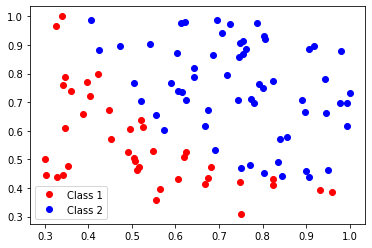

In [2]:
data = np.loadtxt('./Data/data.txt',delimiter=',')

# 标准化,将数据除以最大值，缩放到[0,1]之间
x0_max = data[:,0].max()
x1_max = data[:,1].max()
data[:,0] = data[:,0] / x0_max
data[:,1] = data[:,1] / x1_max

class_1 = data[data[:,2]==0.]
class_2 = data[data[:,2]==1.]

plt.plot(class_1[:,0], class_1[:,1], 'ro', label='Class 1')
plt.plot(class_2[:,0], class_2[:,1], 'bo', label='Class 2')
plt.legend(loc='best')

* 我们要做的事情就是使用 Logistic 回归模型找到以上能分隔蓝色和红色点的线。

* <p>将数据转换成tensor备用。

In [3]:
x_data = torch.from_numpy(data[:, 0:2]).float() # 转换成 Tensor, 大小是 [100, 2]
y_data = torch.from_numpy(data[:, -1]).unsqueeze(1).float() # 转换成 Tensor，大小是 [100, 1]

* 构建 Logistic 模型，sigmoid 函数不需要自己编写，torch.nn.functional 中有丰富的函数库

* <p> **本案例中我们不使用上一个案例中的手动更新梯度，而是采用 PyTorch 提供的优化器，它们都封装在 torch.optim 中，而使用 torch.optim 需要另外一种数据类型，就是 nn.Parameter，这个本质上和 Variable 是一样的，只不过 nn.Parameter 默认是要求梯度的，而 Variable 默认是不求梯度的**

In [4]:
import torch.nn.functional as F
from torch import nn

## 参数
w = nn.Parameter(torch.randn(2, 1))  ## 因为x有两个特征，所以w的size是[2,1]
b = nn.Parameter(torch.zeros(1))

## 模型
def logistic_regression(x):
    return F.sigmoid(torch.mm(x, w) + b)

## 定义优化器
optimizer = torch.optim.SGD([w, b], lr=1.)  ## 使用随机梯度下降(SGD)进行参数更新，参数列表是[w,b]，学习率是lr

* 定义损失函数

In [5]:
def binary_loss(y_pred, y):  ## .clamp(min)是将y_pred最小值限定为1e-12
    logits = (y * y_pred.clamp(1e-12).log() + (1 - y) * (1 - y_pred).clamp(1e-12).log()).mean()
    return -logits

* 迭代更新

In [7]:
# 进行 1000 次更新
import time

start = time.time()
for epoch in range(1000):
    # 前向传播
    y_pred = logistic_regression(x_data)
    loss = binary_loss(y_pred, y_data) # 计算 loss
    
    # 反向传播
    optimizer.zero_grad() # 使用优化器前将梯度归 0
    loss.backward()
    optimizer.step() # 使用优化器来更新参数
    
    # 计算正确率
    mask = y_pred.ge(0.5).float()  ## 大于0.5的返回1，小于0.5的返回0，与sigmoid的输出匹配
    acc = (mask == y_data).sum().item() / y_data.shape[0]
    if (epoch + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch+1, loss.item(), acc))

print('Training time: {:.3f} s'.format(time.time()-start))

C:\Users\zq\Anaconda3\lib\site-packages\torch\nn\functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


epoch: 200, Loss: 0.24859, Acc: 0.89000
epoch: 400, Loss: 0.24154, Acc: 0.89000
epoch: 600, Loss: 0.23609, Acc: 0.89000
epoch: 800, Loss: 0.23175, Acc: 0.89000
epoch: 1000, Loss: 0.22822, Acc: 0.89000
Training time: 0.540 s


* 可以看到使用优化器之后更新参数非常简单，只需要在自动求导之前使用optimizer.zero_grad() 来归 0 梯度，然后使用 optimizer.step()来更新参数就可以了，非常简便。

* 画出更新后的决策边界。在本案例中，我们用的模型其实为

$$
f(x) = \frac{1}{1 + e^{-(w_0x + w_1x + b)}}
$$ 

* 那么最终的决策边界便是学好参数之后的 $-(w_0x + w_1x + b)=0$

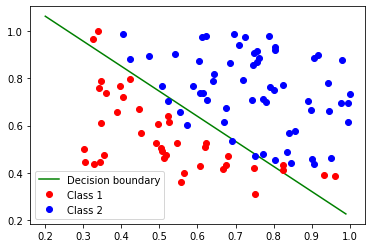

In [8]:
# 画出更新之后的结果
w0 = w[0].item()
w1 = w[1].item()
b0 = b.item()

plot_x = np.arange(0.2, 1, 0.01)
plot_y = (-w0 * plot_x - b0) / w1

plt.plot(plot_x, plot_y, 'g', label='Decision boundary')
plt.plot(class_1[:,0], class_1[:,1], 'ro', label='Class 1')
plt.plot(class_2[:,0], class_2[:,1], 'bo', label='Class 2')
plt.legend(loc='best')

* 可以看到决策边界基本是能将两类点分开的。

* <p> 前面我们使用了自己写的 loss，其实 PyTorch 已经为我们写好了一些常见的 loss，比如线性回归里面的 loss 是 `nn.MSE()`，而 Logistic 回归的二分类 loss 在 PyTorch 中是 `nn.BCEWithLogitsLoss()`，关于更多的 loss，可以查看[官方文档](http://pytorch.org/docs/0.3.0/nn.html#loss-functions)

* <p> PyTorch 为我们实现的 loss 函数有两个好处，第一是方便我们使用，不需要重复造轮子，第二就是其实现是在底层 C++ 语言上的，所以速度上和稳定性上都要比我们自己实现的要好

* <p>另外，PyTorch 出于稳定性考虑，将模型的 Sigmoid 操作和最后的 loss 都合在了 `nn.BCEWithLogitsLoss()`，所以我们使用 PyTorch 自带的 loss 就不需要再加上 Sigmoid 操作了。

In [9]:
# 使用自带的loss
criterion = nn.BCEWithLogitsLoss() # 将 sigmoid 和 loss 写在一层，有更快的速度、更好的稳定性

w = nn.Parameter(torch.randn(2, 1))
b = nn.Parameter(torch.zeros(1))

def logistic_reg(x):
    return torch.mm(x, w) + b  ## 此处不需要做 sigmoid 变换了

optimizer = torch.optim.SGD([w, b], 1.)

In [11]:
# 同样进行 1000 次更新

start = time.time()
for epoch in range(1000):
    # 前向传播
    y_pred = logistic_reg(x_data)
    loss = criterion(y_pred, y_data)
    
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 计算正确率
    mask = y_pred.ge(0.5).float()
    acc = (mask == y_data).sum().item() / y_data.shape[0]
    if (epoch + 1) % 200 == 0:
        print('epoch: {}, Loss: {:.5f}, Acc: {:.5f}'.format(epoch+1, loss.item(), acc))

print('Training time: {:.3f} s'.format(time.time()-start))

epoch: 200, Loss: 0.24859, Acc: 0.89000
epoch: 400, Loss: 0.24155, Acc: 0.89000
epoch: 600, Loss: 0.23609, Acc: 0.89000
epoch: 800, Loss: 0.23175, Acc: 0.89000
epoch: 1000, Loss: 0.22822, Acc: 0.89000
Training time: 0.385 s


* 可以看到，使用了 PyTorch 自带的 loss 之后，速度有了一定的上升，虽然提升并不多，但这只是一个小网络，对于大网络，使用自带的 loss 不管对于稳定性还是速度而言，都有质的飞跃，同时也避免了重复造轮子的困扰。